### Import the datasets

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 

%matplotlib inline

SEED = 2147483647

# read all the names in a python list
with open(file="datasets/names.txt", mode="r") as namesTxt: 
    # names = [line[:-1] for line in namesTxt.readlines()]
    names = namesTxt.read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### Build the datasets

In [2]:
# create the encoder for the letters
chars = ["."] + sorted(list(set("".join(names)))) 
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
vocab_size = len(stoi)

# define the block size of the model
block_size = 3 # context length: how many characters to we consider to predict the next one

# helper function to encode the datasets
def buildDatasets(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return (torch.tensor(X),torch.tensor(Y))

# shuffle the order of the names
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

# build the datasets
xtrain, ytrain = buildDatasets(names[:n1]) # 80%
xtest, ytest = buildDatasets(names[n1:n2]) # 10%
xdev, ydev = buildDatasets(names[n2:]) # 10 %

### Build the Neural Network Library

In [57]:
class Linear:
    
    def __init__(self, fan_in: int, fan_out: int, gen:torch.Generator, biais = True):
        self.weight = torch.randn(size=(fan_in, fan_out), generator = gen) / (fan_in**0.5)
        self.biais = torch.ones(fan_out) if biais else None
        
    def __call__(self, x:torch.Tensor):
        result =  x @ self.weight
        if self.biais is not None:
            result += result + self.biais
        return result
    
    def parameters(self):
        return [self.weight] + ([] if self.biais is None else [self.biais])

class BatchNorm1d:
    
    def __init__(self, num_features: int, eps = 10**-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(size=num_features)
        self.beta = torch.zeros(size=num_features)
        # buffers (parameters used for inferenced, without a gradient)
        self.running_mean = torch.zeros(size=num_features)
        self.running_var = torch.ones(size=num_features)
        
    def __call__(self, x:torch.Tensor):
        
        # forward pass
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True)
        else:
            mean = self.running_mean
            var = self.running_var
        
        # update the buffers (if training)
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * mean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * var
        
        # normalize
        xhat = (x - mean)/(var + self.eps)**0.5
        
        # scale and shift
        self.out = self.gamma * xhat + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x:torch.Tensor):
        self.out = torch.tanh(input=x)
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return "Tanh"

### NN initialization

In [58]:
# Define the variable of the model
n_emb = 10
n_hidden = 100
block_size = 3
g = torch.Generator().manual_seed(SEED) 

# Define the Model
C = torch.randn(size=(vocab_size, n_emb), generator=g)
layers = [
	Linear(fan_in=(n_emb * block_size), fan_out=n_hidden, gen=g),
	Tanh(),
 	Linear(fan_in=n_hidden, fan_out=n_hidden, gen=g),
	Tanh(),
 	Linear(fan_in=n_hidden, fan_out=n_hidden, gen=g),
	Tanh(),
 	Linear(fan_in=n_hidden, fan_out=n_hidden, gen=g),
	Tanh(),
 	Linear(fan_in=n_hidden, fan_out=n_hidden, gen=g),
	Tanh(),
 	Linear(fan_in=n_hidden, fan_out=vocab_size, gen=g),
]

# fine tune initialization:
with torch.no_grad():
	# make the output layer less confident
	layers[-1].weight *= 0.1

	# add some gain to the hidden layers
	for layer in layers[:-1]:
		if isinstance(layer, Linear):
			layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

# add gradient
for p in parameters:
    p.requires_grad = True


46497


### Training the Model

In [53]:
# parameter
max_path = 1
batch_size = 32
lossi = []
high_train = xtrain.shape[0]

for i in range(max_path):
    # construct the minibatch
    ix = torch.randint(low=0, high=high_train, size=(batch_size,), generator=g)
    x_batch, y_batch = xtrain[ix], ytrain[ix]

    # forward pass
    x = C[x_batch].view((batch_size, n_emb * block_size)) # embed the characters into vectors and concatenate them shape = (32,30)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(input=x, target=y_batch)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the weights
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # if i%10000 == 0:
    #     print(f"Loss of batch {i} = {loss.item()}")

    lossi.append(loss.log10().item())

### Visualize the Training 

#### Activation Distribution
<!-- <br> -->
The goal hier is to have a distribution which is not too saturated

In [54]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        l_out = layer.out
        print(f"layer {i}: {layer.__class__}, mean = {l_out.mean():.2f}")

layer 1: <class '__main__.Tanh'>, mean = 0.22
layer 3: <class '__main__.Tanh'>, mean = 0.23
layer 5: <class '__main__.Tanh'>, mean = 0.21
layer 7: <class '__main__.Tanh'>, mean = 0.32
layer 9: <class '__main__.Tanh'>, mean = 0.25


<Figure size 2000x400 with 0 Axes>

In [60]:
print(layers[1])

Tanh


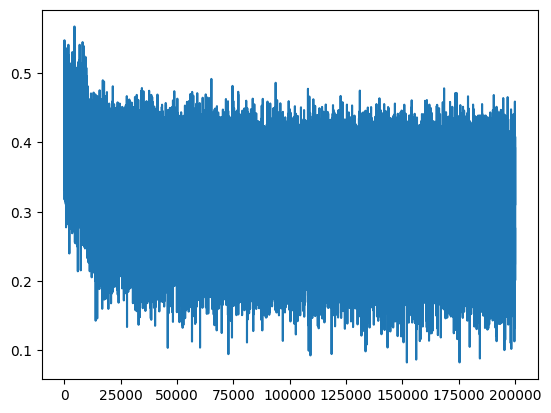

In [37]:
plt.plot(lossi)

### Create MLP

In [5]:
# define the parameters of the MLP
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of hidden layers
g = torch.Generator().manual_seed(SEED) 

# initialization
C = torch.randn(size = (vocab_size, n_embd), generator = g) 
w1 = torch.randn(size=(n_embd * block_size, n_hidden), generator = g)
w1 = w1 * ((5/3) / (n_embd * block_size)**0.5) # normalize for the tanh activation
w2 = torch.randn(size=(n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(size=(vocab_size,), generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbiais = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, w1, w2, b2, bngain, bnbiais]

for p in parameters:
    p.requires_grad = True
print(f"Number of parameters of the MLP = {sum(p.nelement() for p in parameters)}")

Number of parameters of the MLP = 12097


### Train MLP

The loss of the batch Nr.0 = 3.3239
The loss of the batch Nr.10000 = 2.0322
The loss of the batch Nr.20000 = 2.5675
The loss of the batch Nr.30000 = 2.0125
The loss of the batch Nr.40000 = 2.2446
The loss of the batch Nr.50000 = 1.8897
The loss of the batch Nr.60000 = 2.0035
The loss of the batch Nr.70000 = 2.2933
The loss of the batch Nr.80000 = 2.3107
The loss of the batch Nr.90000 = 1.9526


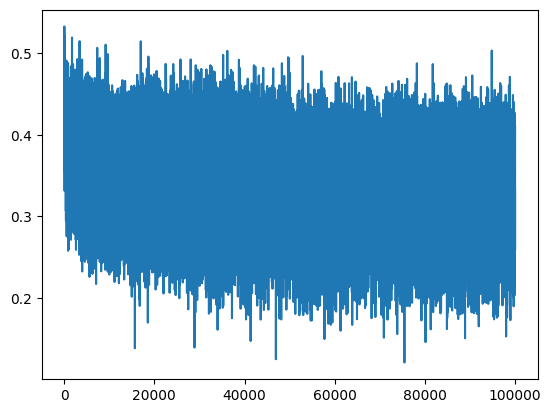

In [6]:
# training parameters
max_path = 100000
batch_size = 32
lossi = []
xtrain_len = xtrain.shape[0]

# forward pass
for i in range(max_path):
    
	# prepare the data of the training batch
	ix = torch.randint(low = 0, high=xtrain_len, size=(batch_size,), generator=g)
	xbatch, ybatch = xtrain[ix], ytrain[ix]

	# forward pass
	# Tensor embedding
	emb = C[xbatch] 
	embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
	
	# first hidden layer
	hpreact = embcat @ w1 # pass through the first hidden layer
	
	# batch normalization layer
	bnmeani = hpreact.mean(0, keepdim=True) # the mean of this batch
	bnstdi = hpreact.std(0, keepdim=True) # the standard deviation of this batch
	hpreact = bngain * ((hpreact - bnmeani)/(bnstdi)) + bnbiais # normalize the batch
	with torch.no_grad():
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # update estimate of global mean
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # update estimate of global standard deviation
	
	# activation normalized layer
	h = torch.tanh(hpreact)
	
	# output
	logits = h @ w2 + b2 # output layer
 
	# loss
	loss = F.cross_entropy(logits, ybatch) # loss function of this batch

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update the weights
	lr = 0.1 if i<50000 else 0.01
	for p in parameters:
		p.data += - lr * p.grad
  
	# print the results once in a while
	if i % 10000 == 0:
		print(f"The loss of the batch Nr.{i} = {loss.item():.4f}")
	lossi.append(loss.log10().item())
 
	# break

# print the evolution of the loss
plt.plot(lossi)

### Helper function to calculate the loss of a dataset

In [7]:
@torch.no_grad() # disable the operation gradient tracking
def print_loss(dataset):
	dic = {
		"train": (xtrain, ytrain),
		"dev": (xdev, ydev),
		"test": (xtest, ytest)
	}
	X, Y = dic[dataset]
	emb = C[X] # embed the characters into tensor
	embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
	hpreact = embcat @ w1
	hpreact = bngain * ((hpreact - bnmean_running)/(bnstd_running)) + bnbiais
	h = torch.tanh(hpreact) # activation function of the first layer
	logits = h @ w2 + b2 # output layer
	loss = F.cross_entropy(logits, Y) # loss function of this batch
	print(f"{dataset} loss = {loss}")
print_loss("train")
print_loss("dev")

train loss = 2.0943093299865723
dev loss = 2.1223857402801514


### Predict new names

In [9]:
# predict names
newNames = []
for i in range (10):
	newName = ""
	context = [0] * block_size
	while True:
		emb = C[context] # embed the characters into tensor
		embcat = emb.view(30) # concatenate the tensors
		hpreact = embcat @ w1 # pass through the first hidden layer
		hpreact = bngain * ((hpreact - bnmean_running)/(bnstd_running)) + bnbiais
		h = torch.tanh(hpreact) # activation function of the first layer
		logits = h @ w2 + b2 # output layer
		proba = logits.exp() / logits.exp().sum()

		i_out = torch.multinomial(
			input=proba,
			num_samples=1,
			replacement=True,
			generator=g,
		).item()

		context = context[1:] + [i_out]
		newName += itos[i_out]

		if i_out == 0:
			break		
	newNames.append(newName)

for name in newNames:
    print(name[:-1])

jaym
kayha
kham
alfiaa
bvettini
soley
cadyn
dilli
evin
kann
